In [223]:
#import sklearn
#!pip uninstall sklearn
#print('The scikit-learn version is {}.'.format(sklearn.__version__))
#scikit-learn v.0.24
#!pip install sklearn
#!pip install sklearn 0.24 

In [224]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from itertools import cycle
from numpy import interp
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, space_eval
from sklearn import svm
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.ensemble import RandomForestClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import RepeatedStratifiedKFold
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
#from sklearn.feature_selection import SequentialFeatureSelector
%matplotlib inline
%run ./classifier_evaluation.ipynb

import dataset

In [225]:
pd.set_option('display.max_columns', None)  # Show all columns
raw_data = pd.read_csv('GENEPY_JULY2021_all.csv')

raw_data.info()

data_1 = raw_data.copy() # Create data copy

data_1 = data_1.infer_objects()  # Automatically correct the data type of each column

data_1.info()

raw_data_2 = pd.read_csv('fuentes_falsePos.csv')

raw_data_2.info()

data_2 = raw_data_2.copy() # Create data copy

data_2 = data_2.infer_objects()  # Automatically correct the data type of each column

data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Columns: 16384 entries, confirmed_diag to ZNF32
dtypes: float64(16378), int64(5), object(1)
memory usage: 135.9+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2156 entries, 0 to 2155
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   a1/3GTP  2156 non-null   object
dtypes: object(1)
memory usage: 17.0+ KB


In [226]:
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'NOT IBD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UC/CD'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'UNKNOWN'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Patchy colitis'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'Other'].index)
data_1 = data_1.drop(data_1[data_1['confirmed_diag'] == 'IBDU '].index)

Remove the false-positive signal features from the lists

In [227]:
fuentes_falsePos_list = list(data_2['a1/3GTP'])[0:]
features_list = list(data_1.columns)[1:]
c = 0
for feature in features_list:
    for fuentes_falsePos in fuentes_falsePos_list:
        if(feature == fuentes_falsePos):
            c+=1
            #print(c)
            #print(feature)
            #print(fuentes_falsePos)
            data_1 = data_1.drop([feature], axis=1)
            break

In [228]:
X3 =  data_1[data_1.columns[0:]]
X3.loc[X3["confirmed_diag"] == "CD", "confirmed_diag"] = 1
X3.loc[X3["confirmed_diag"] == "UC", "confirmed_diag"] = 0
y3 = X3['confirmed_diag']
y3 = y3.astype('int')

data_UC = X3[X3.confirmed_diag == 0]
data_CD = X3[X3.confirmed_diag == 1]

In [229]:
features_list = list(X3.columns)[1:]

fisher_score_list = []
for feature in features_list:
    mUC_feature_mean = data_UC[feature].mean()
    mCD_feature_mean = data_CD[feature].mean()
    sUC_feature_std = data_UC[feature].std()
    sCD_feature_std = data_CD[feature].std()
    m_feature_mean = (mUC_feature_mean - mCD_feature_mean)**2
    s_feature_std = sUC_feature_std**2 + sCD_feature_std**2
    if s_feature_std == 0:
        # 0/0 type also returns nan
        m_fisher_score = 0
    else:
        # Calculate Fisher score
        m_fisher_score = m_feature_mean / s_feature_std
        #Fisher score value added to the list
        #m_fisher_score = '{0:.20f}'.format(m_fisher_score)
    fisher_score_list.append(m_fisher_score)

In [230]:
sorted_fisher_score_list = sorted(enumerate(fisher_score_list), key=lambda x: x[1], reverse = True)

In [231]:
idx = [i[0] for i in sorted_fisher_score_list]
nums = [i[1] for i in sorted_fisher_score_list]

top_5_genes = [features_list[i] for i in idx[0:5]]

top_10_genes = [features_list[i] for i in idx[0:10]]

top_20_genes = [features_list[i] for i in idx[0:20]]

top_50_genes = [features_list[i] for i in idx[0:50]]

top_100_genes = [features_list[i] for i in idx[0:100]]

print("top_5_genes:\n", top_5_genes)
print("top_10_genes\n", top_10_genes)
print("top_20_genes\n", top_20_genes)
print("top_50_genes\n", top_50_genes)
print("top_100_genes\n", top_100_genes)

top_5_genes:
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7']
top_10_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50']
top_20_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 'AGO1', 'ERAP1', 'TRIM63', 'CYP4F11', 'ARHGEF7']
top_50_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 'AGO1', 'ERAP1', 'TRIM63', 'CYP4F11', 'ARHGEF7', 'MGAT2', 'LNX2', 'SULT1A1', 'SLC4A2', 'ZBTB20', 'ADAMTS20', 'EPS15L1', 'C2orf69', 'MRPL36', 'ARHGEF10L', 'ODF2L', 'TRIM64C', 'NRN1L', 'PSMD13', 'ARF3', 'ADAM29', 'BRINP2', 'AURKA', 'TNFAIP8', 'CRISP2', 'THNSL1', 'USP40', 'XPC', 'SV2C', 'FNBP1', 'LRP8', 'ARAP1', 'ITPR3', 'RNF19B', 'CX3CR1']
top_100_genes
 ['NOD2', 'ASPM', 'GPAA1', 'HCN1', 'PSMB7', 'FAM155A', 'ACSM6', 'MS4A10', 'AVPR1B', 'NUP50', 'CFAP58', 'NANS', 'PNKD', 'SPTSSB', 'MET', 

In [232]:
X3 = X3.drop(['confirmed_diag'], axis=1)

In [233]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = 0.30, random_state = 42)
X3_100_train = X3_train.loc[:, top_100_genes]
X3_100_test = X3_test.loc[:, top_100_genes]
y3_train = y3_train.astype('int')
y3_test = y3_test.astype('int')

Sequential Feature Selector

In [234]:
#SVM_classifier_1 = svm.SVC(kernel = 'linear', probability=True, random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)

#SVM_classifier_1 = Pipeline([('scaler', MinMaxScaler()), ('linearsvc', LinearSVC(random_state=0, tol=1e-5,class_weight='balanced', max_iter=10000))])
#SVM_classifier_1 = Pipeline([('scaler', MinMaxScaler()), ('SVC', svm.SVC(C=2.2455112829618873, gamma='scale', probability=True, kernel='rbf', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000))])
RF_classifier_1 = RandomForestClassifier(n_jobs=-1, random_state=0)
#min_max_scaler = preprocessing.MinMaxScaler()
#X3 = min_max_scaler.fit_transform(X3)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)
sfs = SFS(RF_classifier_1, 
           k_features=10, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='accuracy',
           cv=10)

sfs = sfs.fit(X3_100_train, y3_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.5min finished

[2021-09-23 13:01:33] Features: 1/10 -- score: 0.6798778230285081[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:  1.5min finished

[2021-09-23 13:03:01] Features: 2/10 -- score: 0.6934653831914106[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:  1.5min finished

[2021-09-23 13:04:29] Features: 3/10 -- score: 0.6989078119215105[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [239]:
print('\nSequential Forward Selection (k=10):')
print(sfs.k_feature_idx_)
print(sfs.k_feature_names_)
print('CV Score:')
print(sfs.k_score_)


Sequential Forward Selection (k=10):
(8, 9, 15, 26, 59, 64, 70, 81, 84, 89)
('AVPR1B', 'NUP50', 'AGO1', 'EPS15L1', 'RALGPS1', 'UEVLD', 'TCEANC2', 'APOC3', 'CDS1', 'ACTA2')
CV Score:
0.7301554979637171


In [240]:
sfs.subsets_

{1: {'feature_idx': (26,),
  'cv_scores': array([0.67567568, 0.67567568, 0.68918919, 0.64864865, 0.68493151,
         0.67123288, 0.71232877, 0.68493151, 0.68493151, 0.67123288]),
  'avg_score': 0.6798778230285081,
  'feature_names': ('EPS15L1',)},
 2: {'feature_idx': (8, 26),
  'cv_scores': array([0.67567568, 0.68918919, 0.71621622, 0.68918919, 0.67123288,
         0.65753425, 0.67123288, 0.7260274 , 0.71232877, 0.7260274 ]),
  'avg_score': 0.6934653831914106,
  'feature_names': ('AVPR1B', 'EPS15L1')},
 3: {'feature_idx': (8, 26, 89),
  'cv_scores': array([0.67567568, 0.67567568, 0.74324324, 0.7027027 , 0.68493151,
         0.65753425, 0.67123288, 0.7260274 , 0.7260274 , 0.7260274 ]),
  'avg_score': 0.6989078119215105,
  'feature_names': ('AVPR1B', 'EPS15L1', 'ACTA2')},
 4: {'feature_idx': (8, 26, 81, 89),
  'cv_scores': array([0.67567568, 0.71621622, 0.74324324, 0.7027027 , 0.68493151,
         0.65753425, 0.67123288, 0.7260274 , 0.73972603, 0.7260274 ]),
  'avg_score': 0.70433172898

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


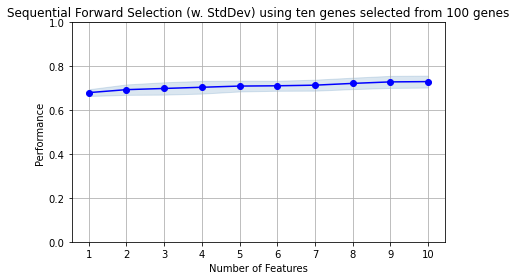

In [241]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0, 1])
plt.title('Sequential Forward Selection (w. StdDev) using ten genes selected from 100 genes')
plt.grid()

plt.tight_layout()
plt.savefig('fig63.eps', dpi=400, format='eps', bbox_inches = 'tight')
plt.show()

In [244]:
#X3_10 = data_1.loc[:, ['NOD2','TEK','PLCL1','SP110','SNAPC4','ITPR3','CYP1B1','FCRL5','CX3CR1','TNFSF11']].values
#y3 = y3.astype('int').values

X3_train_sfs = sfs.transform(X3_100_train)
X3_test_sfs = sfs.transform(X3_100_test)
y3_train = y3_train.astype('int')
y3_test = y3_test.astype('int')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

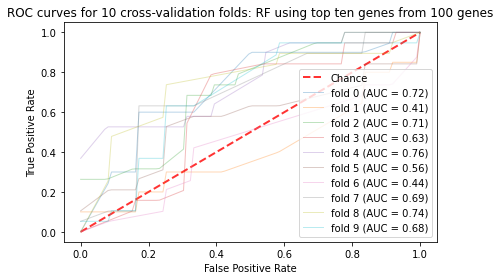

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

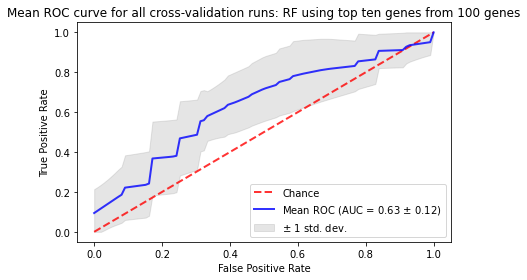

In [249]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_3, f1_scores_SVM_3, tprs_SVM_3, aucs_SVM_3 = evaluate_classifier(folds=10, 
                                                                        p=X3_test_sfs, t=y3_test, 
                                                                        classifier=RF_classifier_1, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_3, aucs_SVM_3, 'RF using top ten genes from 100 genes')
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_3, aucs_SVM_3, 'RF using top ten genes from 100 genes')

In [167]:
# step1: 定义目标函数
def objective(params):
    # 初始化模型并交叉验证
    svc = svm.SVC(**params)
    cv_scores = cross_val_score(svc, X3_train_sfs, y3_train, cv=10)
    # 返回loss = 1 - accuracy (loss必须被最小化)
    loss = 1 - cv_scores.mean()
    return loss

# step2: 定义超参搜索空间
space = {'kernel':hp.choice('kernel', ['linear', 'rbf']),
         'C':hp.uniform('C', 1, 10), 
          'probability':hp.choice('probability',[True]),
          'gamma': hp.choice('gamma', ['scale', 'auto'])}

#step3: 在给定超参搜索空间下，最小化目标函数
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

# step4: 打印结果
print(best)

100%|██████████| 100/100 [00:28<00:00,  3.45trial/s, best loss: 0.28750462791558695]
{'C': 2.2455112829618873, 'gamma': 0, 'kernel': 1, 'probability': 0}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

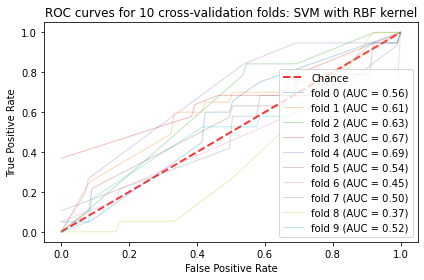

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

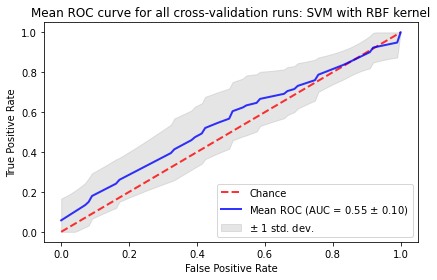

In [168]:
#linear_SVM_classifier_1 = LinearSVC(random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
SVM_classifier_3 = svm.SVC(C=2.2455112829618873, gamma='scale', probability=True, kernel='rbf', random_state=0, tol=1e-5, class_weight='balanced', max_iter=10000)
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_SVM_3, f1_scores_SVM_3, tprs_SVM_3, aucs_SVM_3 = evaluate_classifier(folds=10, 
                                                                        p=X3_test_sfs, t=y3_test, 
                                                                        classifier=SVM_classifier_3, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM_3, aucs_SVM_3, 'SVM with RBF kernel')
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM_3, aucs_SVM_3, 'SVM with RBF kernel')

In [246]:
space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200])
    }

def objective(space):
    model_3 = RandomForestClassifier(criterion = space['criterion'], 
                                   max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model_3, X3_train_sfs, y3_train, cv = 10).mean()

    # We aim to maximize accuracy, therefore we return it as a negative value
    return {'loss': -accuracy, 'status': STATUS_OK }
    
trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 80,
            trials= trials)
best

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200}

trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], 
                                       max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]
                                      ).fit(X3_train_sfs,y3_train)

100%|██████████| 80/80 [07:09<00:00,  5.37s/trial, best loss: -0.7274713069233617]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

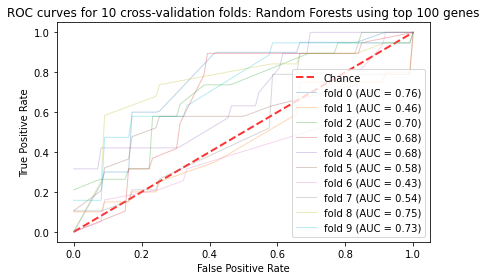

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

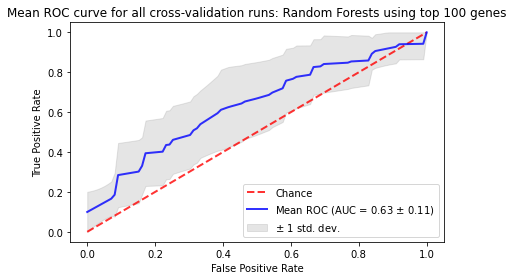

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


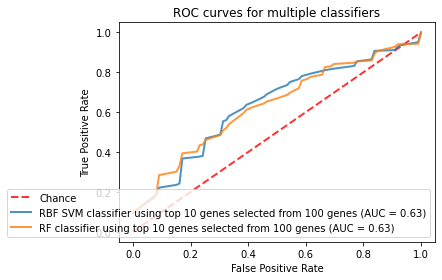

In [247]:
mean_fpr = np.linspace(start=0, stop=1, num=100)
# used below to scale all predictor values to the range [0, 1]
# this is done separately for each fold in cross validation
min_max_scaler = preprocessing.MinMaxScaler()

# Train and evaluate the classifier by applying 5-fold cross validation.
# We use 5 folds only, because the data set is rather small.
accuracies_RF_4, f1_scores_RF_4, tprs_RF_4, aucs_RF_4 = evaluate_classifier(folds=10, 
                                                                        p=X3_test_sfs, t=y3_test, 
                                                                        classifier=trainedforest, 
                                                                        mean_fpr=mean_fpr)
# runs k-fold cross validation to measure various metrics of a classifier:
#        accuracies - an array of accuracies for each fold
#        f1_scores - an array of F1-scores (also known as F-scores) for each fold
#        tprs - true positive rates, one per cross-validation fold
#        aucs - areas below the ROC curve, one per cross-validation fold

# Plot an ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_RF_4, aucs_RF_4, 'Random Forests using top 100 genes')

# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_RF_4, aucs_RF_4, 'Random Forests using top 100 genes')

plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM_3, axis=0), np.mean(tprs_RF_4, axis=0))), 
                              np.array([np.mean(aucs_SVM_3), np.mean(aucs_RF_4)]), 
                              np.array(['RBF SVM classifier using top 10 genes selected from 100 genes', 'RF classifier using top 10 genes selected from 100 genes']))